# SPI modelling

**Introduction:**

The following notebook gives examples of how to call three main time series forecasting models including, LSTM, ARIMA and ARIMA_LSTM models. In addition, extensions to these models through data filtering by (SG) and/or by performing decomposition preprocessing with CEEMDAN are provided

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#Insert the directoryimport sys
import sys
sys.path.insert(0,'/content/drive/MyDrive/Colab Notebooks/Decomp_LSTM')

In [3]:
# Installation of additional packages required for the project
!pip install ewtpy
!pip install keras-tuner
!pip install EMD-signal
!pip install SciencePlots
!pip install SciencePlots==2.0.0
!pip install pmdarima

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 128.9/128.9 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.6/74.6 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.5/78.5 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.8/56.8 kB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.1
    Uninstalling tqdm-4.66.1:
      Successfully uninstalled tqdm-4.66.1
  Attempting uninstall: SciencePlots
    Found existing installation: SciencePlots 2.1.1
    Uninstalling SciencePlots-2.1.1:
      Successfully uninstalled SciencePlots-2.1.1
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 9.5 MB/s eta 0:00:00


In [4]:
from datetime import datetime
#import numpy as np             #for numerical computations like log,exp,sqrt etc
#import pandas as pd            #for reading & storing data, pre-processing
import matplotlib.pylab as plt #for visualization
#for making sure matplotlib plots are generated in Jupyter notebook itself
%matplotlib inline
import pmdarima as pmd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 10, 6
from scipy import stats as st
import matplotlib.dates as mdates

import scipy
import statsmodels.api as sm
import sklearn
import warnings
warnings.filterwarnings("ignore")

In [5]:
import pandas as pd
import numpy as np
#import matplotlib.pyplot as plt
import Decompose_LSTMs_v2 as dl
import time
#import stringency_dates_extractor as sde
#plt.style.use(['science','notebook'])
#pd.set_option('precision', 2)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


Tensor Flow Version: 2.14.0

Python 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
Pandas 1.5.3
Scikit-Learn 1.2.2
GPU is available


In [6]:
#plt.style.use(['science','notebook']) # instal by: pip install SciencePlots==1.0.9
%matplotlib inline
# A date in Python is not a data type of its own,
# but we can import a module named datetime to work with dates as date objects.
import datetime
from sklearn.preprocessing import MinMaxScaler
import matplotlib.dates as mdates
import scienceplots
import numpy as np
# https://pypi.org/project/SciencePlots/
plt.style.use(['science','notebook']) # instal by: pip install SciencePlots==1.0.9
%matplotlib inline


## Importing data for running tests


In [ ]:
gust = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Decomp_LSTM/Hybrid_DeepLearning_Model/hermanus.csv',sep=";")

In [ ]:
gust.shape

(9394, 11)

In [ ]:
gust['Date']=pd.to_datetime(gust[['Year','Month','Day']])

In [ ]:
hermanus_gust = gust[['Date','Windgust']]

In [ ]:
data1_new = hermanus_gust.set_index('Date')

In [ ]:
hermanus_gust_int = data1_new.interpolate(method ='spline',order = 1, limit_direction ='forward')

In [ ]:
hermanus_gust_int.head()

,Windgust
Date,
1995-01-01,11.0
1995-01-02,12.0
1995-01-03,6.0
1995-01-04,7.0
1995-01-05,7.0


## Exploratory Analysis
We focus more here on assessing the ACF and PACF functions to help with determing a suitable window size for contructing the training set.

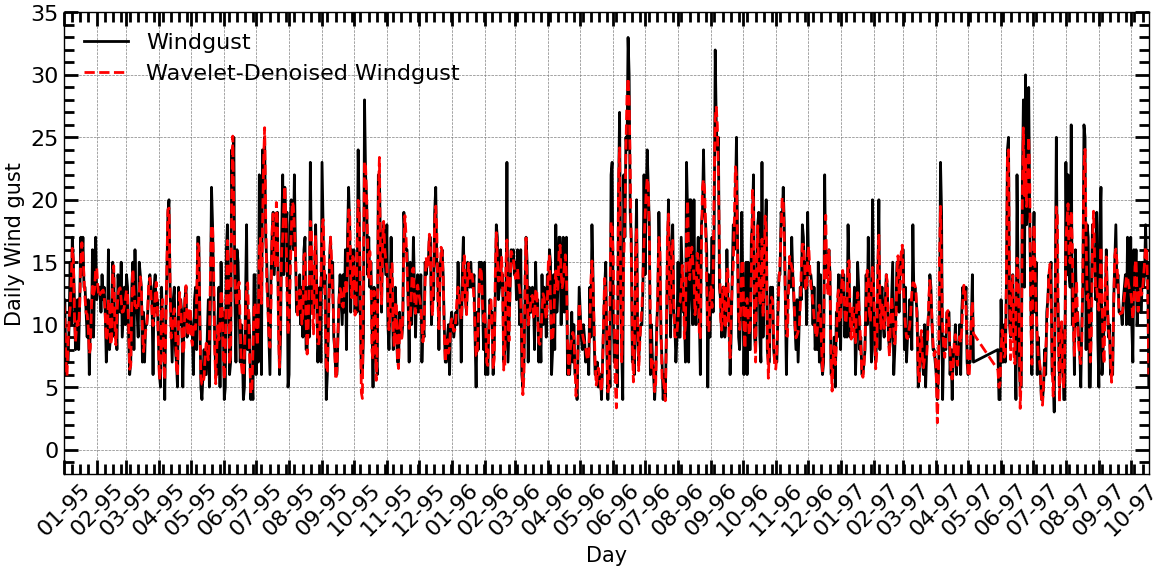

In [ ]:
#wavelet denoising the daily cases to see the impact of denoising on data series
herm_gust_for_plot = hermanus_gust_int.head(1000)
Wd = dl.wave(herm_gust_for_plot)
#Wd = dl.wave(SA_daily_cases)
#Time series plot
# Create figure object and store it in a variable called 'fig'
fig, ax = plt.subplots(figsize = (14,6))
# Edit the major and minor ticks of the x and y
ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')
ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')
# plotting daily data
# see: https://e2eml.school/matplotlib_lines.html for line colours
ax.plot(herm_gust_for_plot.iloc[len(Wd)*-1:].index, herm_gust_for_plot['Windgust'].iloc[len(Wd)*-1:], color='black', label="Windgust")
# plotting 4-day rolling data
ax.plot(herm_gust_for_plot.iloc[len(Wd)*-1:].index, Wd, color='red', linestyle='dashed',label="Wavelet-Denoised Windgust")
# Beautification of plot
#ax.xaxis.set_major_locator(mdates.DayLocator(interval=1)) ####
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%y'))
ax.legend()
ax.set_xlabel('Day', fontsize=15)
#ax.set_ylabel('NO2 (mol/m2)', fontsize=15)
ax.set_ylabel("Daily Wind gust", fontsize=15)
plt.setp(plt.gca().xaxis.get_majorticklabels(),'rotation', 45);
ax.set_xlim([herm_gust_for_plot.index[0], herm_gust_for_plot.index[-1]])
# Set the axis limits
maxy = int(herm_gust_for_plot.max() + 2)
ax.set_ylim(-2, maxy)
plt.grid(color = 'gray', linestyle = '--', linewidth = 0.5)
plt.show()
#ax.set_ylim(-0.2, 2.2)
#plt.savefig('/content/drive/MyDrive/Colab Notebooks/Decomp_LSTM/Results/Wind_gust_hermanus.png')

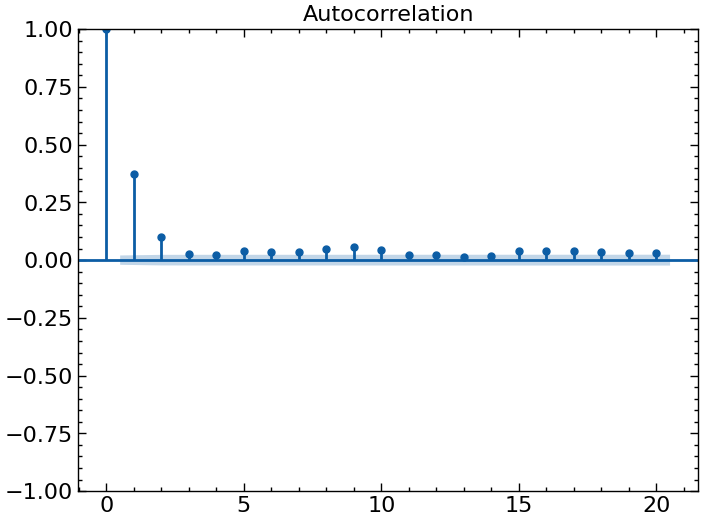

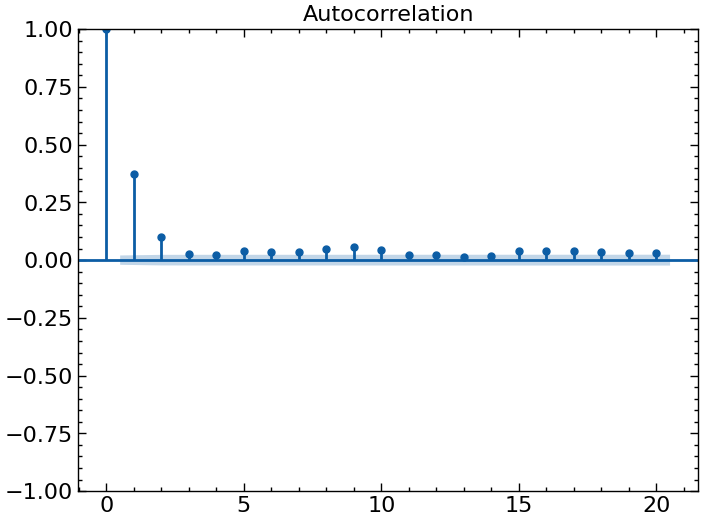

In [ ]:
# Auto correlation functions
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(hermanus_gust_int, lags=20)


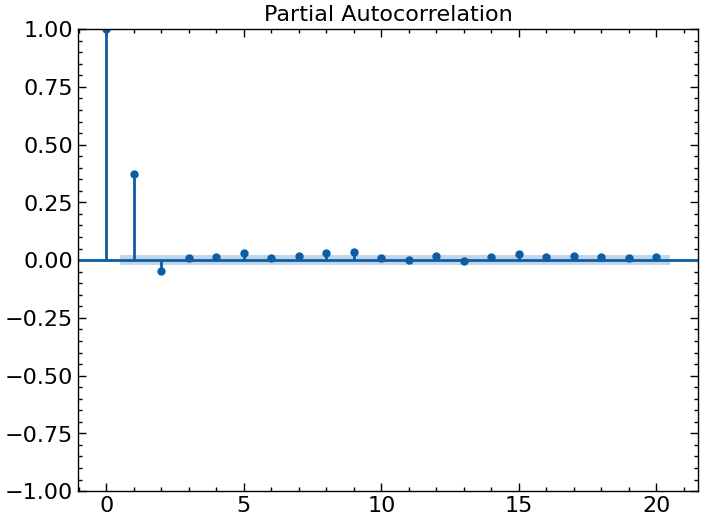

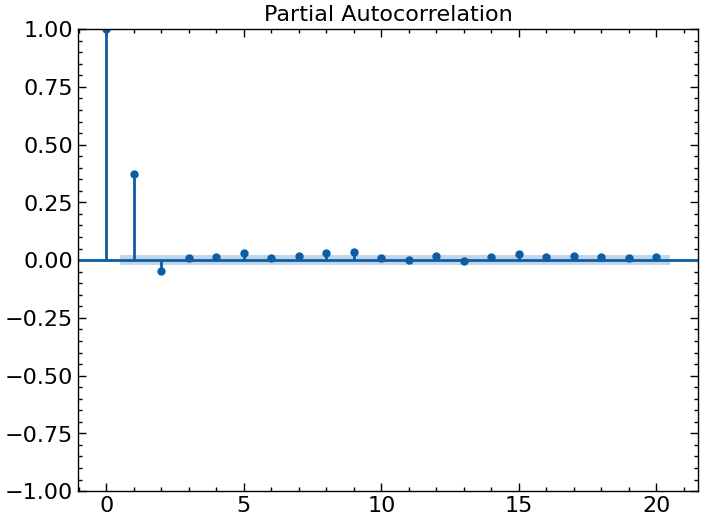

In [ ]:
#Partial Auto Correlation function
plot_pacf(hermanus_gust_int, lags=20)

In [ ]:
# These plots shorter window sizes will do better

In [ ]:
# Train-test splitting function
def train_test(timeseries,test_prop = 0.05):
    """ train test splitting function. Splits the function according to the given train_size proportions
        Inputs: The series to be split into training and testing sets and the proportion you want for the
                training set
        Outputs: Two arrays, which are respectively the training and testing sets."""
    train_size = int(len(timeseries) * (1-test_prop))
    test_size = len(timeseries) - train_size
    train, test = timeseries.iloc[0:-test_size], timeseries.iloc[-test_size:]
    return (train, test)

In [ ]:
t1, t2 = train_test(hermanus_gust_int[['Windgust']])

In [ ]:
t2.head().shape

(5, 1)

In [ ]:
#Decomposition for test


In [ ]:
t2.head().shape[0]

5

In [ ]:
for i in range(t2.head().shape[0]):
  trn = t1.append(t2.head(i+1))
  IMFs_numpy = dl.EEMD_decomp(trn)
  IMFs_df = pd.DataFrame(data=IMFs_numpy, columns=[f'col{i+1}' for i in range(IMFs_numpy.shape[1])],index = [f'IMF{i+1}' for i in range(IMFs_numpy.shape[0])])
  imfs_table_name = f'EEMD_IMFs{i+1}'
  IMFs_df.to_csv(f'/content/drive/MyDrive/Colab Notebooks/Decomp_LSTM/IMFs/{imfs_table_name}.csv')

In [ ]:
import_imf_forecasted = dl.LSTM_forecast_over_test_IMFs(5,window_size = 1,train_val_proportion = 0.7, batch_size=15,epochs = 2,tuner_epochs = 3,max_trials=2,saving = True, model_name="EEMD_LSTM",Decomposition='EEMD')

Trial 2 Complete [00h 00m 18s]
mean_squared_error: 0.01819060742855072

Best mean_squared_error So Far: 0.013364390470087528
Total elapsed time: 00h 00m 43s
Epoch 1/2
417/417 [==============================] - 7s 11ms/step - loss: 0.0275 - mean_squared_error: 0.0275 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 2/2
417/417 [==============================] - 3s 7ms/step - loss: 0.0134 - mean_squared_error: 0.0134 - val_loss: 0.0128 - val_mean_squared_error: 0.0128


Epoch 1/2
591/595 [============================>.] - ETA: 0s - loss: 0.0137 - mean_squared_error: 0.0137


Epoch 1: loss improved from inf to 0.01365, saving model to /content/drive/MyDrive/Colab Notebooks/Decomp_LSTM/IMFs_models/TPE_EEMD_LSTM_IMF1.hdf5
595/595 [==============================] - 6s 8ms/step - loss: 0.0136 - mean_squared_error: 0.0136
Epoch 2/2
586/595 [============================>.] - ETA: 0s - loss: 0.0131 - mean_squared_error: 0.0131


Epoch 2: loss improved from 0.01365 to 0.01314, saving model to /content/drive/MyDrive/Colab Notebooks/Decomp_LSTM/IMFs_models/TPE_EEMD_LSTM_IMF1.hdf5
595/595 [==============================] - 4s 7ms/step - loss: 0.0131 - mean_squared_error: 0.0131
hist_EEMD_LSTM_IMF1_history saved successfully


hist_full_EEMD_LSTM_IMF1_history saved successfully

Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
352               |352               |units1
sigmoid           |sigmoid           |activation
0.0001            |0.0001            |learning_rate



Epoch 1/3
  1/417 [..............................] - ETA: 11:47 - loss: 0.4004 - mean_squared_error: 0.4004

## LSTM, SG-LSTM, CEEMDAN-LSTM and SG-CEEMDAN-LSTM

All four models will be trained and used for forecasting values over the test dataset by using one function TPE_multiple_predictions *(train,test,model_name="LSTM", batch_size = 5,epochs = 10, SG = False, Decompose=False, window_size=7)* and adjusting the "SG" and "Decompose" parameters. For example by having "SG = False, Decompose=False" you configure for a standard LSTM, by "SG = True, Decompose=False" you configure for SD-LSTM, etc.

This will apply to the other two models following with the only difference being the forecasting models, that is, ARIMA and ARIMA-LSTM.

In [ ]:
# LSTM
tic = time.perf_counter()
predictions_LSTM = dl.LSTM_forecast_over_test(t1, t2.head(),window_size = 2,train_val_proportion = 0.8, batch_size=150,epochs = 2,tuner_epochs = 2,max_trials=2, Waveletdenoise = False, SG = False, Decompose=False,decomp_approach='',saving = True, model_name="LSTM")
toc = time.perf_counter()
print(f"The models run in {(toc - tic)/60:0.3f} minutes ")


In [ ]:
# CEEMDAN-LSTM
tic = time.perf_counter()
predictions_LSTM = dl.LSTM_forecast_over_test(t1, t2.head(),window_size = 2,train_val_proportion = 0.8, batch_size=150,epochs = 2,tuner_epochs = 2,max_trials=2, Waveletdenoise = False, SG = False, Decompose=True,decomp_approach='EEMD',saving = True, model_name="LSTM")
toc = time.perf_counter()
print(f"The models run in {(toc - tic)/60:0.3f} minutes ")


Trial 2 Complete [00h 00m 04s]
mean_squared_error: 0.19293633103370667

Best mean_squared_error So Far: 0.16725172102451324
Total elapsed time: 00h 00m 08s
Epoch 1/2
48/48 [==============================] - 2s 12ms/step - loss: 0.1985 - mean_squared_error: 0.1985 - val_loss: 0.1582 - val_mean_squared_error: 0.1582
Epoch 2/2
48/48 [==============================] - 1s 11ms/step - loss: 0.1765 - mean_squared_error: 0.1765 - val_loss: 0.1386 - val_mean_squared_error: 0.1386


Epoch 1/2
56/60 [===========================>..] - ETA: 0s - loss: 0.1892 - mean_squared_error: 0.1892


Epoch 1: loss improved from inf to 0.18980, saving model to /content/drive/MyDrive/Colab Notebooks/Decomp_LSTM/Saved_models/TPE_LSTM_IMF5.hdf5
60/60 [==============================] - 3s 16ms/step - loss: 0.1898 - mean_squared_error: 0.1898
Epoch 2/2
55/60 [==========================>...] - ETA: 0s - loss: 0.1655 - mean_squared_error: 0.1655


Epoch 2: loss improved from 0.18980 to 0.16395, saving model to /content/drive/MyDrive/Colab Notebooks/Decomp_LSTM/Saved_models/TPE_LSTM_IMF5.hdf5
60/60 [==============================] - 0s 7ms/step - loss: 0.1640 - mean_squared_error: 0.1640
hist_LSTM_IMF5_history saved successfully
hist_full_LSTM_IMF5_history saved successfully


1/1 [==============================] - 0s 132ms/step
The models run in 6.789 minutes 


In [ ]:
t1.values[-(2):].reshape(1,1,2)

array([[[9., 6.]]])

In [ ]:
a = np.array([2,4])
a.reshape(1,2,1)

array([[[2],
        [4]]])

In [ ]:
#
# SG-LSTM
tic = time.perf_counter()
SG_LSTM = dl.TPE_multiple_predictions(t1,t2,model_name="SG_LSTM", batch_size = 5,epochs = 10, SG = True, Decompose=False, window_size=7)
toc = time.perf_counter()
print(f"The models run in {(toc - tic)/60:0.3f} minutes ")


In [ ]:
forecasted['SG_LSTM'] = SG_LSTM

In [ ]:
#
# CEEMDAN-LSTM
tic = time.perf_counter()
CEEMDAN_LSTM = dl.TPE_multiple_predictions(t1,t2,model_name="CEEMDAN_LSTM", batch_size = 5,epochs = 10, SG = False, Decompose=True, window_size=7)
toc = time.perf_counter()
print(f"The models run in {(toc - tic)/60:0.3f} minutes ")


In [ ]:
forecasted['CEEMDAN_LSTM'] = CEEMDAN_LSTM

In [ ]:
#
# SG-CEEMDAN-LSTM
tic = time.perf_counter()
SG_CEEMDAN_LSTM = dl.TPE_multiple_predictions(t1,t2,model_name="SG_CEEMDAN_LSTM", batch_size = 5,epochs = 10, SG = True, Decompose=True, window_size=7)
toc = time.perf_counter()
print(f"The models run in {(toc - tic)/60:0.3f} minutes ")


NameError: ignored

In [ ]:
forecasted['SG_CEEMDAN_LSTM'] = SG_CEEMDAN_LSTM

## ARIMA, SG-ARIMA, CEEMDAN-ARIMA and SG-CEEMDAN-ARIMA


In [ ]:
#ARIMA_forecast_over_test(train,test,SG = False,Decompose = False, model_name = "CEEMDAN_ARIMA")

In [ ]:
#
# ARIMA
tic = time.perf_counter()
ARIMA = dl.ARIMA_forecast_over_test(t1,t2,model_name="ARIMA", SG = False, Decompose=False)
toc = time.perf_counter()
print(f"The models run in {(toc - tic)/60:0.3f} minutes ")


In [ ]:
forecasted['ARIMA'] = ARIMA

In [ ]:
#
# SG-ARIMA
tic = time.perf_counter()
SG_ARIMA = dl.ARIMA_forecast_over_test(t1,t2,model_name="SG_ARIMA", SG = True, Decompose=False)
toc = time.perf_counter()
print(f"The models run in {(toc - tic)/60:0.3f} minutes ")


In [ ]:
forecasted['SG_ARIMA'] = SG_ARIMA

In [ ]:
#
# CEEMDAN-ARIMA
tic = time.perf_counter()
CEEMDAN_ARIMA = dl.ARIMA_forecast_over_test(t1,t2,model_name="CEEMDAN_ARIMA", SG = False, Decompose=True)
toc = time.perf_counter()
print(f"The models run in {(toc - tic)/60:0.3f} minutes ")


In [ ]:
forecasted['CEEMDAN_ARIMA'] = CEEMDAN_ARIMA

In [ ]:
#
# SG-CEEMDAN-ARIMA
tic = time.perf_counter()
SG_CEEMDAN_ARIMA = dl.ARIMA_forecast_over_test(t1,t2,model_name="SG_CEEMDAN_ARIMA", SG = True, Decompose=True)
toc = time.perf_counter()
print(f"The models run in {(toc - tic)/60:0.3f} minutes ")


In [ ]:
forecasted['SG_CEEMDAN_ARIMA'] = SG_CEEMDAN_ARIMA

ARIMA-LSTM, SG-ARIMA-LSTM, CEEMDAN-ARIMA-LSTM and SG-CEEMDAN-ARIMA-LSTM

In [ ]:
#
# ARIMA-LSTM
tic = time.perf_counter()
ARIMA_LSTM = dl.multiple_pred(t1,t2, model_name = 'ARIMA_LSTM', SG = False,Decompose=False,window_size = 7,val_split=0.2,batch_size=15,epochs=10)
toc = time.perf_counter()
print(f"The models run in {(toc - tic)/60:0.3f} minutes ")


In [ ]:
forecasted['ARIMA_LSTM'] = ARIMA_LSTM

In [ ]:
#
# SG-ARIMA-LSTM
tic = time.perf_counter()
SG_ARIMA_LSTM = dl.multiple_pred(t1,t2, model_name = 'SG_ARIMA_LSTM', SG = True,Decompose=False,window_size = 7,val_split=0.2,batch_size=15,epochs=10)
toc = time.perf_counter()
print(f"The models run in {(toc - tic)/60:0.3f} minutes ")


In [ ]:
forecasted['SG_ARIMA_LSTM'] = SG_ARIMA_LSTM

In [ ]:
#
# CEEMDAN-ARIMA-LSTM
tic = time.perf_counter()
CEEMDAN_ARIMA_LSTM = dl.multiple_pred(t1,t2, model_name = 'CEEMDAN_ARIMA_LSTM', SG = False,Decompose=True,window_size = 7,val_split=0.2,batch_size=15,epochs=10)
toc = time.perf_counter()
print(f"The models run in {(toc - tic)/60:0.3f} minutes ")


In [ ]:
forecasted['CEEMDAN_ARIMA_LSTM'] = CEEMDAN_ARIMA_LSTM

In [ ]:
#
# SG-CEEMDAN-ARIMA-LSTM
tic = time.perf_counter()
SG_CEEMDAN_ARIMA_LSTM = dl.multiple_pred(t1,t2, model_name = 'SG_CEEMDAN_ARIMA_LSTM', SG = True,Decompose=True,window_size = 7,val_split=0.2,batch_size=15,epochs=10)
toc = time.perf_counter()
print(f"The models run in {(toc - tic)/60:0.3f} minutes ")


In [ ]:
forecasted['SG_CEEMDAN_ARIMA_LSTM'] = SG_CEEMDAN_ARIMA_LSTM

In [ ]:
## saving the actual, prediction from all models table
forecasted.to_csv('/content/drive/MyDrive/Colab Notebooks/Decomp_LSTM/Hybrid_DeepLearning_Model/Results/forecasted_all.csv')

### To this point all required models have been run and a table containing the test data and forecasts from all models herein.

## From hereon we have a few code left in the cells for probable future use.

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df['spi6'],label='actual')
plt.plot(df['lstm_predicted'], label = 'lstm_predicted')
plt.legend()

In [ ]:
dl.evaluation(df_SG['spi6'].values,df_SG['sg_lstm_predicted'].values)

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(df_SG['spi6'],label='actual')
plt.plot(df_SG['sg_lstm_predicted'], label = 'sg_lstm_predicted')
plt.legend()

In [ ]:
# Plotting IMF's
# Obtaining IMF's
IMFs = dl.CEEMDAN_decomp(data_spi6_)

In [ ]:
IMFs_df = pd.DataFrame(data=IMFs.T, columns = [f'IMF{i+1}' for i in range(IMFs.shape[0])],index= data_spi6_.index )

In [ ]:
#Adapting to SPI plots
imf_num = [i+1 for i in range(IMFs.shape[0])]

fig, axes = plt.subplots(nrows=6, figsize=(20, 15))
# Edit the major and minor ticks of the x and y


plt.subplots_adjust(hspace=0.50)
for i, ax in enumerate(axes):
    col_scheme=np.where(IMFs_df['IMF'+str(imf_num[i])]>0, 'b','r')
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax.bar(IMFs_df.index, IMFs_df['IMF'+str(imf_num[i])], width=25, align='center', color=col_scheme)
    ax.axhline(y=0, color='k')
    ax.xaxis.set_major_locator(mdates.YearLocator(2))
    ax.legend(loc='upper right', fontsize=12)
    ax.set_yticks(range(-2,2))

    ax.yaxis.set_tick_params(which='major', size=10, width=2, direction='in', right='on')
    ax.yaxis.set_tick_params(which='minor', size=7, width=2, direction='in', right='on')
    ax.xaxis.set_tick_params(which='major', size=10, width=2, direction='in', top='on')
    ax.xaxis.set_tick_params(which='minor', size=7, width=2, direction='in', top='on')

    for label in (ax.get_xticklabels() + ax.get_yticklabels()):
        label.set_fontsize(16)

    plt.setp(plt.gca().xaxis.get_majorticklabels(),
         'rotation', 45)

    ax.set_ylabel('IMF'+str(imf_num[i]), fontsize=15)
    ax.set_ylabel('IMF'+str(imf_num[i]), fontsize=15)
    #ax.set_title('Cape Town', fontsize=10)

    ax.grid(True)
    #if i<len(times)-1:
        #ax.set_xticks([],[])
    #label='SPI '+str(times[i])
#plt.savefig('Results/CapeTown_SPI.png')


In [ ]:
dl.IMFs_plotter(IMFs, decomposition_method="CEEMDAN")

# Questionable functions below

# Model Comparison Plots

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(SG_ARIMA_LSTM['spi6'],label='actual', linestyle="-")
plt.plot(SG_ARIMA_LSTM['predicted_SG_Arima_LSTM'], label = 'SG_ARIMA_LSTM', linestyle="--")
plt.plot(ARIMA_LSTM['predicted_Arima_LSTM'], label = 'ARIMA_LSTM', linestyle="-.")
plt.plot(CEEMDAN_LSTM['ceemdan_lstm_predicted'], label = 'CEEMDAN_LSTM', linestyle=".")
plt.plot(df_SG['sg_lstm_predicted'], label = 'SG_LSTM', linestyle=",")
plt.plot(df['lstm_predicted'], label = 'LSTM', linestyle="-.")
plt.plot(df['Arima_predicted'], label = 'ARIMA')
plt.plot(df['Sg_Arima_predicted'], label = 'SG_ARIMA')
plt.plot(df['CEEMDAN_Arima_predicted'], label = 'CEEMDAN_ARIMA', linestyle="-.")
plt.plot(CEEMDAN_ARIMA_LSTM['predicted_CEEMDAN_Arima_LSTM'], label = 'CEEMDAN_ARIMA_LSTM', linestyle="+")
plt.plot(SG_CEEMDAN_ARIMA_LSTM['predicted_CEEMDAN_Arima_LSTM'], label = 'CEEMDAN_ARIMA_LSTM', linestyle="*")
plt.legend()